## Occasionally dishonest casino
First, we are trying to generate data for the example of the occasionally dishonest casino (see Murphy 17.4). The idea behind the example is that die rolls are generated from a global state, which is either **fair** (each die face is equally likely) or **loaded** (one die face, here 6, has a higher probability than the others). Below the transition diagram is drawn, showing the transition probabilities of the global states along arrows, and individual die roll probabilities of each state inside the box. Let's implement a function that returns rolls as well as the die state for given sequence lengths.

<img src="img/casino.png" width="400">

In [65]:
import numpy as np
np.random.seed(0)

### defintions/parameters
die_states = ['F', 'L']                                    # hidden state (F is fair, L is loaded)
faces = [1, 2, 3, 4, 5, 6]                                 # observable state space
obsModel = np.array([[1/6, 1/6, 1/6, 1/6, 1/6, 1/6],
                    [1/10, 1/10, 1/10, 1/10, 1/10, 5/10]]) # observable state probabilities for given hidden state 
transition_matrix = np.array([[0.95, 0.05],[0.1, 0.90]])   # hidden state transition matrix

### function that returns observed (rolls) and hidden states (die) for given sequence lengths
def rolling_dice(n=300):
    dice = np.zeros(n, dtype=str)
    rolls = np.zeros(n, dtype=np.int32)
    # Generate random initial hidden state
    start_rv = np.random.rand()
    if start_rv <= 0.5: # initial hidden states are equally likely
        die = 0
    else:
        die = 1
    # Roll the dice for n times
    for i in range(n):
        dice[i] = die_states[die]
        rolls[i] = np.random.choice(faces, p=obsModel[die])
        trans_rv = np.random.rand()
        if trans_rv > transmat[die][die]:
            die ^= 1
    return rolls, dice

In [66]:
from sklearn.preprocessing import OneHotEncoder
T = 300
rolls, dice = rolling_dice(T)
enc = OneHotEncoder()
rolls_onehot = enc.fit_transform(rolls.reshape(-1, 1)).toarray()

[6 6 6 6 3 4 6 1 5 6 6 6 6 6 5 6 6 6 6 5 3 1 5 1 3 3 2 2 3 3 2 2 4 1 1 3 6
 1 2 2 5 6 3 1 6 6 6 2 1 1 3 6 6 6 6 6 3 4 6 6 6 4 4 2 2 3 2 4 4 3 3 6 5 6
 6 6 4 6 4 1 3 6 6 4 2 1 1 3 6 1 6 3 4 4 2 2 6 3 2 3 5 2 1 3 6 3 3 6 4 6 6
 6 6 3 5 2 1 3 3 4 1 1 3 2 3 6 5 1 4 3 2 6 6 6 5 6 6 6 5 6 6 1 1 5 6 2 2 3
 6 6 5 1 2 1 1 1 1 2 4 5 1 2 3 5 3 5 5 5 3 2 2 1 1 2 6 1 4 5 1 6 6 3 3 3 5
 2 4 1 6 4 3 6 6 2 4 5 6 6 4 2 6 6 5 3 1 5 3 3 1 6 6 1 3 1 3 6 6 5 3 5 6 1
 3 6 6 6 2 2 1 6 3 5 2 2 2 6 6 5 6 5 3 5 6 6 4 4 3 2 3 4 3 5 6 1 3 3 5 5 3
 6 2 5 3 6 3 3 2 1 5 6 4 4 1 6 4 1 6 1 5 6 2 6 6 6 6 1 3 4 6 6 6 1 3 1 6 6
 6 6 5 6]
['L' 'L' 'L' 'L' 'F' 'F' 'F' 'F' 'F' 'F' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L'
 'L' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'F'
 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L'
 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F'
 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L'
 'L' 'L' 'F' 'F' 'F' 'F' 

In [67]:
from itertools import compress
class HMM:
    def __init__(self, pi_0, A, B, data):
        self.pi = pi
        self.A = np.array(A)
        self.B = B
        self.data = data
        self.N = len(self.pi)
        self.T, self.M = self.data.shape
        self.Z = np.zeros(self.T, dtype=np.int)
        self.alpha = np.zeros((self.T, self.N))
        self.beta = np.zeros((self.T, self.N))
        self.delta = np.zeros((self.T, self.N))

    def normalize(self, a):
        return a / np.sum(a)


    def find_B_w_O(self, t):
        result = []
        for i in range(self.N):
            result.append(list(compress(self.B[i], self.data[t]))[0])
        return result

In [68]:
class HMMForwards(HMM):    
    def __init__(self, *args):
        HMM.__init__(self, *args)
    
    def forwards(self):
        # p(q(t)|O(1), ...., O(t))
        unnormalized = np.multiply(self.pi, self.find_B_w_O(0))
        self.alpha[0] = self.normalize(unnormalized)
        self.Z[0] = np.sum(unnormalized)
        logZ = np.log(self.Z[0] + 1e-7)

        for t in range(1, self.T):
            unnormalized = np.multiply(np.dot(self.alpha[t-1], self.A), self.find_B_w_O(t))
            self.alpha[t] = self.normalize(unnormalized)
            self.Z[t] = np.sum(unnormalized)
            logZ += np.log(self.Z[t] + 1e-7)

        return self.alpha, self.Z, logZ

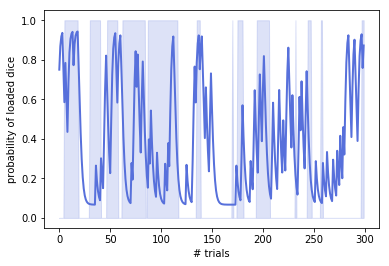

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Encoding die as categorical variable
die_df = pd.DataFrame(die, columns=['die'])
die_df.die = pd.Categorical(die_df.die)
die_df['code'] = die_df.die.cat.codes

# Estimate alpha
hmm = HMMForwards(.5, transition_matrix, obsModel, rolls_onehot)
alpha, _, _ = hmm.forwards()

# plot the estimated alpha and actual hidden states
mycolor = sns.color_palette("hls", 8)[5]
plt.fill_between(range(300), 0, die_df['code'],
                 color=mycolor, alpha=0.2)
alpha_df = pd.DataFrame(alpha)
alpha_df.iloc[:, 1].plot(color=mycolor, linewidth=2)
plt.xlabel("# trials")
plt.ylabel("probability of loaded dice")
plt.show()

In [70]:
class HMMForwardsBackwards(HMMForwards):
    def __init__(self, *args):
        HMMForwards.__init__(self, *args)
        
    def backwards(self):
        self.beta[-1] = np.ones(self.N)
        for t in range(self.T - 2, -1, -1):
            self.beta[t] = self.normalize(np.dot(np.transpose(self.A),
                                  np.multiply(self.find_B_w_O(t + 1), self.beta[t + 1])))
        return self.beta

    def smoothing(self):
        # gamma(i, t) = p(S(t) = i|O(1:T))
        self.alpha, _, logZ = self.forwards()
        self.beta = self.backwards()
        gamma = np.multiply(self.alpha, self.beta)

        # normalize gamma to make the rowsum equal to 1
        _sum = gamma.sum(1)
        for n in range(self.N):
            gamma[:, n] = gamma[:, n]/ _sum
        return gamma

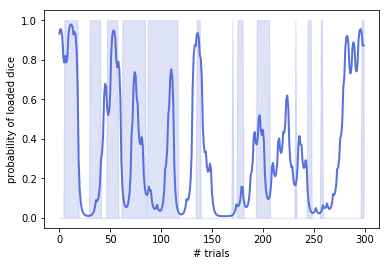

In [71]:
hmm = HMMForwardsBackwards(.5, transition_matrix, obsModel, rolls_onehot)
gamma = hmm.smoothing()

# plot the estimated gamma and actual hidden states
mycolor = sns.color_palette("hls", 8)[5]
plt.fill_between(range(300), 0, die_df['code'],
                 color=mycolor, alpha=0.2)
gamma_df = pd.DataFrame(gamma)
gamma_df.iloc[:, 1].plot(color=mycolor, linewidth=2)
plt.xlabel("# trials")
plt.ylabel("probability of loaded dice")
plt.show()

In [72]:
class HMMViterbi(HMM):
    def __init__(self, *args):
        HMM.__init__(self, *args)
        
    def viterbi(self):
        # Initialization
        delta = np.zeros((self.T, self.N))
        psi = np.zeros((self.T, self.N), dtype=np.int)
        optimal_path = np.zeros(self.T, dtype=np.int)
        delta[0] = np.multiply(self.pi, self.find_B_w_O(0))

        # Induction
        for t in range(1, self.T):
            for n in range(self.N):
                delta[t, n] = np.max(delta[t-1] * self.A[:, n]) * self.find_B_w_O(t)[n]
                psi[t, n] = np.argmax(delta[t-1] * self.A[:, n])

        # Termination
        p_star = np.max(self.delta[-1])
        optimal_path[-1] = np.argmax(delta[-1])

        # Backtracking the path
        for t in range(self.T-2, -1, -1):
            optimal_path[t] = psi[t + 1, optimal_path[t + 1]]

        return p_star, optimal_path

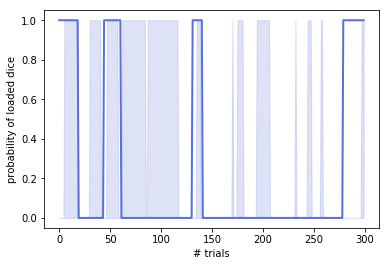

In [73]:
hmm = HMMViterbi(.5, transition_matrix, obsModel, rolls_onehot)
p_star, optimal_path = hmm.viterbi()
# plot the estimated gamma and actual hidden states
mycolor = sns.color_palette("hls", 8)[5]
plt.fill_between(range(300), 0, die_df['code'],
                 color=mycolor, alpha=0.2)
plt.plot(optimal_path, color=mycolor, linewidth=2)
plt.xlabel("# trials")
plt.ylabel("probability of loaded dice")
plt.show()

In [75]:
threshold = 0.5
tmp = pd.concat([die_df['code'], alpha_df.iloc[:, 1] > threshold,
                 gamma_df.iloc[:, 1] > threshold, pd.Series(optimal_path)], 1)
tmp.columns = ['actual', 'filtering', 'smoothing','MAP']
for inference in tmp.columns[1:]:
    print("The accuracy of {}: {:.2f}".format(inference, np.mean(tmp.actual == tmp.loc[:, inference])))

The accuracy of filtering: 0.58
The accuracy of smoothing: 0.61
The accuracy of MAP: 0.58
